# Setup and Dependencies

In [ ]:
# 0. Connect your Google Drive

# a. Import required package
from google.colab import drive

# b. Mount drive
drive.mount('/content/drive')

# c. Navigate to the folder of this class
%cd /content/drive/MyDrive/COMP488 Class Project
%pwd

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/16OvjFliUAcnxcNhlykoxQT7c7V5LeKRs/COMP488 Class Project


'/content/drive/.shortcut-targets-by-id/16OvjFliUAcnxcNhlykoxQT7c7V5LeKRs/COMP488 Class Project'

In [ ]:
import locale
print(locale.getpreferredencoding())

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
# Run in case of locale errors
# locale.getpreferredencoding = getpreferredencoding
print(locale.getpreferredencoding())

ANSI_X3.4-1968
UTF-8


In [ ]:
!pip install tweet-preprocessor emoji pandera
!pip install vaderSentiment sentence-transformers bertopic
!pip install altair scikit-learn scipy pyarrow\
  'numpy==1.23.0' plotly tqdm nltk spacy # pandas matplotlib
!pip install Cython torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.3/149.3 kB 20.3 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=36cc2fec727534ba2bc4823c6427bb0116d9de2cf4a584772063f2552f04211e
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import logging
import re
from collections import Counter
from pathlib import Path
from typing import List, Tuple, Union

import altair as alt
import emoji
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import preprocessor as prepro
import scipy
import sklearn
import spacy
import torch
from bertopic import BERTopic
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from pandera import (Check, Column, DataFrameSchema, Index, check_io,
                     check_output)
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split)
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Preprocessing Section

In [ ]:
# data_dir = Path('Data').absolute()
data_path = Path('/content/drive/MyDrive/COMP488 Class Project/Data')
prepro.set_options(prepro.OPT.URL, prepro.OPT.RESERVED, prepro.OPT.MENTION, prepro.OPT.HASHTAG)
tokenizer = 'nltk'  # or spacy
if tokenizer == 'spacy':
    spacy_tokenizer = spacy.load('en_core_web_sm')

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

# Use empty list to not filter
include_words = []

# include_words = [
#     'flavor',
#     'taste',
#     'fluoride',
#     'mint',
#     'price',
#     'breath',
#     'peppermint',
#     'whitening',
#     'aftertaste',
#     'plaque',
#     'spearmint',
#     'color',
#     'texture',
#     'tongue',
#     'taste',
#     'whiten',
#     'clean',
#     'burn',
#     'eat',
#     'flavor',
#     'smell',
#     'spit',
#     'foam',
#     'kill',
# ]

dirty_amazon_schema = DataFrameSchema(
    {
        "productAsin": Column(),
        "username": Column(),
        "ratingScore": Column(),
        "reviewTitle": Column(),
        "reviewUrl": Column(nullable=True),
        "reviewReaction": Column(),
        "reviewedIn": Column(),
        "date": Column(np.datetime64),
        "country": Column(),
        "countryCode": Column(nullable=True),
        "reviewDescription": Column(),
        "isVerified": Column(),
        "avatar": Column(),
        "variant": Column(),
        "reviewImages": Column(),
        "position": Column(),
    },
    index=Index(int),
    strict=True,
)
clean_amazon_schema = DataFrameSchema(
    {
        "review": Column(str),
        "rating": Column(),
        "source": Column(str),
    },
    index=Index(np.datetime64, name='date'),
    strict=False,  # keep more columns if you want
)

dirty_reddit_schema = DataFrameSchema(
    {
        '_type': Column(),
        'author': Column(),
        'body': Column(nullable=True),
        'date': Column(np.datetime64),
        'id': Column(),
        'parentId': Column(np.float64, nullable=True),
        'subreddit': Column(),
        'url': Column()
    }
)
clean_reddit_schema = DataFrameSchema(
    {
        'review': Column(str),
        'source': Column(str),
    },
    index=Index(np.datetime64, name='date'),
    strict=False,  # keep more columns if you want
)
dirty_twitter_schema = DataFrameSchema(
    {
        '_type': Column(),
        'url': Column(),
        'date': Column(np.datetime64),
        'rawContent': Column(),
        'renderedContent': Column(),
        'id': Column(np.int64),
        'user': Column(),
        'replyCount': Column(np.int64),
        'retweetCount': Column(np.int64),
        'likeCount': Column(np.int64),
        'quoteCount': Column(np.int64),
        'conversationId': Column(np.int64),
        'lang': Column(),
        'source': Column(),
        'sourceUrl': Column(),
        'sourceLabel': Column(),
        'links': Column(nullable=True),
        'media': Column(nullable=True),
        'retweetedTweet': Column(np.float64, nullable=True),
        'quotedTweet': Column(nullable=True),
        'inReplyToTweetId': Column(np.float64, nullable=True),
        'inReplyToUser': Column(nullable=True),
        'mentionedUsers': Column(nullable=True),
        'coordinates': Column(nullable=True),
        'place': Column(nullable=True),
        'hashtags': Column(nullable=True),
        'cashtags': Column(nullable=True),
        'card': Column(nullable=True),
        'viewCount': Column(np.float64, nullable=True),
        'vibe': Column(nullable=True),
    }
)
clean_twitter_schema = DataFrameSchema(
    {
        'review': Column(str),
        'source': Column(str),
    },
    index=Index(np.datetime64, name='date'),
    strict=False,  # keep more columns if you want
)

generic_clean_schema = clean_twitter_schema


@check_output(dirty_amazon_schema)
def load_amazon() -> pd.DataFrame:
    return pd.read_json(data_dir/'Amazon/Amazon-TomsofMaine-Reviews-AutoProxyUS.json')


def _glob_json_loader(folder_path: Path) -> pd.DataFrame:
    df = pd.DataFrame()
    files = folder_path.glob('*.json')
    for fpath in tqdm(files, position=0, leave=True):
        df1 = pd.read_json(fpath, lines=True)
        df = pd.concat([df, df1])
    return df


@check_output(dirty_reddit_schema)
def load_reddit() -> pd.DataFrame:
    logger.info('Reading reddit files...')
    df = _glob_json_loader(data_dir/'Reddit/TomsofMaine')
    df.date = df.date.dt.tz_localize(None)  # tz aware (UTC) to naive
    return df


@check_output(dirty_twitter_schema)
def load_twitter() -> pd.DataFrame:
    logger.info('Reading twitter files...')
    df = _glob_json_loader(data_dir/'Twitter')
    df.date = df.date.dt.tz_localize(None)  # tz aware (UTC) to naive
    return df

#@check_output(dirty_twitter2_schema)
#def load_twitter2() -> pd.DataFrame:
#    logger.info('Reading twitter files...')
#    df = _glob_json_loader(data_dir/'Twitter2')
#    df.date = df.date.dt.tz_localize(None)  # tz aware (UTC) to naive
#    return df

@check_io(
    df=dirty_amazon_schema,
    out=clean_amazon_schema,
)
def clean_amazon(df: pd.DataFrame) -> pd.DataFrame:
    result = df[['reviewDescription', 'date', 'ratingScore']]
    result = result.set_index('date')
    result = result.rename(columns={
        'reviewDescription': 'review',
        'ratingScore': 'rating'
    })
    result['review'] = clean_reviews(result['review'])
    result['rating'] = result['rating'].astype(int)
    result['source'] = 'amazon'
    return result


@check_io(
    df=dirty_reddit_schema,
    out=clean_reddit_schema,
)
def clean_reddit(df: pd.DataFrame) -> pd.DataFrame:
    result = df[['body', 'date']]
    result = result.set_index('date')
    result = result.rename(columns={
        'body': 'review',
    })
    result['review'] = clean_reviews(result['review'])
    result['source'] = 'reddit'
    return result


@check_io(
    df=dirty_twitter_schema,
    out=clean_twitter_schema,
)
def clean_twitter(df: pd.DataFrame) -> pd.DataFrame:
    result = df[['rawContent', 'likeCount', 'viewCount', 'date']]
    result = result.set_index('date')
    result = result.rename(columns={
        'rawContent': 'review',
        'likeCount': 'like_count',
        'viewCount': 'view_count',
    })
    result['review'] = clean_reviews(result['review'])
    result['source'] = 'twitter'
    return result



def clean_reviews(srs: pd.Series):
    return srs.str.lower()\
    .apply(_remove_non_ascii)\
    .apply(prepro.clean)\
    .apply(_process_special)\
    .apply(_remove_punctuation)\
    .apply(_remove_stop_words)\
    .apply(_remove_html)


def _remove_non_ascii(s):
    return "".join(i for i in str(s) if ord(i) < 128)


def _remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if w not in stops]
    return " ".join(text)


def _remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)


def _remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    return " ".join(text)


def _process_special(sentence):
    sentence = str(sentence)

    # 1. Replace anything after @ with empty string
    sentence = re.sub("@[A-Za-z0-9]+", "", sentence)

    # 2. Replace url links with empty string
    sentence = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", sentence)
    sentence = sentence.replace("#", "").replace("_", " ")

    # 3. Emoji patterns
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    emoji_pattern.sub(r'', sentence)

    # 4. Replace acronyms with full-forms.
    # 5. If you want to include add a new line re.sub(r'\ACRONYM\b', ' FULL FORM ', sentence) for each acronym
    re.sub(r'\bICYMI\b', ' in case you missed it ', sentence)
    re.sub(r'\bAFAIAC\b', ' As Far As I Am Concerned ', sentence)
    re.sub(r'\bAFAIK\b', ' As Far As I Know ', sentence)
    re.sub(r'\bASAP\b', ' As soon as possible ', sentence)
    re.sub(r'\bBFF\b', ' Best Friends Forever ', sentence)
    re.sub(r'\bDM\b', ' Doesnt Matter ', sentence)
    re.sub(r'\bFYI\b', ' For Your Information ', sentence)
    re.sub(r'\bGN\b', ' Good Night ', sentence)
    re.sub(r'\bHAGT\b', ' Have A Great Time ', sentence)
    re.sub(r'\bHTH\b', ' Hope That Helps ', sentence)
    re.sub(r'\bIDK\b', " I Don't Know ", sentence)
    re.sub(r'\bIJK\b', " I'm Just kidding ", sentence)
    return sentence


@check_io(
    df=generic_clean_schema,
    out=generic_clean_schema,
)
def filter_reviews(df: pd.DataFrame) -> pd.DataFrame:
    def keep_sentence(s: str) -> bool:
        matched = re.findall(r"(?=("+'|'.join(include_words)+r"))", s.lower())
        return bool(matched)
    mask = df.review.apply(keep_sentence)
    return df[mask]


def tokenize_review(review: str) -> list:
    """Sentence tokenizer."""
    if tokenizer == 'spacy':
        sentences = spacy_tokenizer(review)
        return [s.text for s in sentences.sents]
    if tokenizer == 'nltk':
        return nltk.sent_tokenize(review)
    raise ValueError()


@check_io(
    clean_df=generic_clean_schema,
    out=generic_clean_schema,
)
def _generic_pipeline(clean_df: pd.DataFrame) -> pd.DataFrame:
    result_df = clean_df
    clean_rows = len(clean_df)
    if include_words:  # empty list to not filter
        logger.debug('Filtering...')
        result_df = filter_reviews(clean_df)
    logger.debug(f"""
        clean shape: {clean_rows}
        filt shape: {result_df.shape[0]}
        dropped rows: {result_df.shape[0]-clean_rows}
        """)
    logger.debug('Tokenizing...')
    result_df['review'] = result_df.review.apply(tokenize_review)
    result_df = result_df.explode('review')
    logger.debug(f'shape: {result_df.shape}')
    result_df = result_df.dropna(subset=['review'])
    logger.debug(f'out shape: {result_df.shape}')
    return result_df


def main(source_name: str, n: int = None):
    df = None
    if source_name.lower() == 'amazon':
        df = load_amazon()
        df = clean_amazon(df)
        save_path = data_dir/'Amazon/cleaned.parquet'
    elif source_name.lower() == 'reddit':
        df = load_reddit()
        df = clean_reddit(df)
        save_path = data_dir/'Reddit/cleaned.parquet'
    elif source_name.lower() == 'twitter':
        df = load_twitter()
        df = clean_twitter(df)
        save_path = data_dir/'Twitter/cleaned.parquet'

    if n:  # for debugging
        logger.info(f'clipping to {2*int(n/2)} obs')
        df = pd.concat(
            (df.head(int(n/2)), df.tail(int(n/2)))
        )
    df = _generic_pipeline(df)
    df.to_parquet(save_path)
    logger.info(f'Saved cleaned data to {save_path}')

In [ ]:
# main('amazon')
# main('reddit')
# main('twitter')
#main('twitter2')

INFO:__main__:Reading reddit files...
132it [00:07, 18.19it/s]
DEBUG:__main__:
        clean shape: 13047
        filt shape: 13047
        dropped rows: 0
        
DEBUG:__main__:Tokenizing...
DEBUG:__main__:shape: (13047, 2)
DEBUG:__main__:out shape: (13042, 2)
INFO:__main__:Saved cleaned data to /content/drive/MyDrive/COMP488 Class Project/Data/Reddit/cleaned.parquet


In [ ]:
%reset -f --aggressive
import gc
gc.collect()

culling sys module...


56

# Analysis Section

In [ ]:
# pandarallel.initialize(progress_bar=True)
pio.templates.default = 'plotly_white'
pio.templates[pio.templates.default].layout.colorway = ['rgb(65,182,196)', 'rgb(201,148,199)', 'rgb(255,210,0)']
pio.renderers.default = 'colab'
data_dir = Path('data').absolute()

np.__version__  # ensure <1.24.0 due to numba errors


'1.23.0'

In [ ]:
data_path = Path('/content/drive/MyDrive/COMP488 Class Project/Data')
amazon_df = pd.read_parquet(data_path/'Amazon/cleaned.parquet')
print(amazon_df.info())
print()
reddit_df = pd.read_parquet(data_path/'Reddit/cleaned.parquet')
print(reddit_df.info())
print()
twitter_df = pd.read_parquet(data_path/'Twitter/cleaned.parquet')
twitter2_df = pd.read_parquet(data_path/'Twitter2/cleaned.parquet')
print(twitter_df.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24418 entries, 2022-11-22 to 2021-01-29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  24418 non-null  object
 1   rating  24418 non-null  int64 
 2   source  24418 non-null  object
dtypes: int64(1), object(2)
memory usage: 763.1+ KB
None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13042 entries, 2022-09-28 23:07:55 to 2012-07-03 02:15:48
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  13042 non-null  object
 1   source  13042 non-null  object
dtypes: object(2)
memory usage: 305.7+ KB
None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15289 entries, 2016-03-30 18:35:21 to 2017-12-02 09:39:39
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   review      15289 non-null  object 
 1   like_count  15289 non-null  int

In [ ]:
all_df = pd.concat((
    amazon_df[['review', 'source']],
    twitter_df[['review', 'source']],
    reddit_df[['review', 'source']],
    twitter2_df[['review', 'source']],
), axis=0)

# adf needs an id column so we can filter adf by the index values in pos_filt_df
all_df['id'] = range(len(all_df))
# all_df.info()
all_df.head()

,review,source,id
2022-11-22,love toothpaste teeth looks cleaner using one,amazon,0
2022-10-02,really good nice soft,amazon,1
2022-03-28,favorite toothbrush im alway lookin one glad f...,amazon,2
2021-03-16,despite words 4 pack images showing four tooth...,amazon,3
2021-04-26,ordered four pack received four pack excellent...,amazon,4


In [ ]:
print('Dropping duplicates:', all_df.shape[0]-all_df.drop_duplicates('review').shape[0])
all_df.drop_duplicates('review', inplace=True)

Dropping duplicates: 17653


In [ ]:
adf = all_df

In [ ]:
# pio.templates.default = ''
tlist = ['ggplot2',
  'seaborn',
  'simple_white',
  'plotly',
  'plotly_white',
  'plotly_dark',
  'presentation',
 ]
# for t in tlist:
#   px.bar(adf.groupby(adf.index.strftime('%Y-%m')).count().iloc[:,0], template=t, title=t).show()
fig = px.bar(adf.groupby(adf.index.strftime('%Y-%m')).count().iloc[:,0])
# pio.templates.
fig.update_layout().show()


# Filter only TP Reviews

In [ ]:
!pip install transformers #already done in this full notebook
#if shown UTF-8 error message, go back to the second cell and follow instructions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import transformers as ppb
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# load model
output_dir = '/content/drive/MyDrive/COMP488 Class Project/model_TP/'

# 3. Note. If you have different model (eg: BERT) during training change the appropriate name here.
model_name = 'distilbert-base-cased'
#model_name = 'bert-base-cased'

tokenizer = AutoTokenizer.from_pretrained(model_name)
numclasses = 2
model = AutoModelForSequenceClassification.from_pretrained(
		output_dir,
		output_hidden_states=False,
		output_attentions=False,
		num_labels=numclasses
)
# predict labels
# filter out non-tp labels

In [ ]:
# 1. Set the maximum length value
padding_type = 'max_length'

# 2. Restrict to maximum length 75 to save RAM memory
# Note: Use the same 'max_length' in training and testing.
max_length = 75

# 3. Function to tokenize the sentences and return tokens and padding
def tokenize_sentences(sent):
  input_ids = []
  attention_mask = []
  token_ids = []

  for i in tqdm(range(len(sent))):
    sentence = sent[i]
    encoded = tokenizer.encode_plus(text=sentence,
                                    add_special_tokens=True,
                                    padding=padding_type,
                                    max_length=max_length,
                                    truncation=True,
                                    return_token_type_ids=True,
                                    return_tensors='pt')

    input_ids.append(encoded['input_ids'])
    attention_mask.append(encoded['attention_mask'])

  input_ids = torch.cat(input_ids, dim=0, out=None)
  attention_mask = torch.cat(attention_mask, dim=0, out=None)

  return input_ids, attention_mask
#4. Prepare New Sentences
New_Sentences = adf.review.values
test_input_ids, test_attention_mask = tokenize_sentences(New_Sentences)

# 1. Load utilities from pytorch
from torch.utils.data import TensorDataset, DataLoader

# 2. Convert data in correct formats
test_array = TensorDataset(test_input_ids, test_attention_mask)
test_loader = DataLoader(test_array, batch_size=8)

# 1. Import TrainingArguments from huggingface
from transformers import TrainingArguments, Trainer

# 2. Define the training args
training_args = TrainingArguments(
		output_dir=' ',
		logging_dir=' ',
		)

# 3. Load the trainer class from huggingface
# We will set train_dataset and eval_dataset to test_loader
trainer = Trainer(
		model=model,
		args=training_args,
		train_dataset=test_loader,
		eval_dataset=test_loader
		)


100%|██████████| 37880/37880 [00:41<00:00, 914.08it/s] 


In [ ]:
%%time
# 1. Set the model to evalution mode
model.eval()

# 2. Use GPU as primary device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 3. Store the list of predictions
test_pred_labels = []
test_pred_scores = []
with torch.no_grad():
    for input_ids, attn_mask in test_loader:
        input_ids = input_ids.to(device)
        attn_mask = attn_mask.to(device)
        outputs = model(input_ids, attn_mask)
        outputs = outputs['logits']
        test_pred_labels.extend(torch.argmax(outputs, 1).cpu().detach().numpy().tolist())
        test_pred_scores.extend(torch.max(torch.softmax(outputs, 1), 1)[0].cpu().detach().numpy().tolist())

# 4. Create a dataframe to store sentences and predicted labels
# df = pd.DataFrame({'sentences': New_Sentences,
#                    'predicted_labels': test_pred_labels,
#                    'predicted_scores': test_pred_scores
#                    })
adf['predicted_labels'] = test_pred_labels
adf['predicted_scores'] = test_pred_scores

CPU times: user 1min 29s, sys: 347 ms, total: 1min 29s
Wall time: 1min 34s


In [ ]:
assert (New_Sentences == adf.review).all()

In [ ]:
print(device)
#check if running GPU session

cuda


In [ ]:
# hack
df = adf

In [ ]:
# 1. Let's see what our fine-tuned model classified as positive samples
pd.set_option('max_colwidth', 300) # make sure we can see all the sentences
display(df[df.predicted_labels==1].sort_values(by=['predicted_scores']))

# 2. Let's see what our fine-tuned model classified as negative samples
pd.set_option('max_colwidth', 300) # make sure we can see all the sentences
display(df[df.predicted_labels==0].sort_values(by=['predicted_scores']))


,review,source,id,predicted_labels,predicted_scores
2022-04-21 02:43:28,got fam gt stephen crichton count lucky joe tapine know back gt gt canberra raiders prop bottle pound mongrel ounce white line fever makes competitive beast gt gt could simply taught penrith centre meaning word respect much tyson frizell quite rightly allowed zac lomax weekend gt gt good guy nor...,reddit,41926,1,0.500033
2013-10-10 22:39:54,know tom maine partially owned colgate palmolive company matters interesting know source,reddit,49715,1,0.500045
2022-07-02 05:50:37,yeah sorry toms prick summer absolutely knew wanted ignored desires much like saying want casual boundary honor saying want one ignore reverse genders make girl hopelessly love guy keeps interested get laid bars closed really clear person also asshole matter many times said didnt want relationsh...,reddit,41352,1,0.500077
2015-01-09 23:33:13,angel wheels healing winner provides aid patients traveling treatments hats,twitter,32447,1,0.500093
2020-10-20 13:13:47,goal series congressional district population roughly 50 000 series begin state least amount seats wyoming 11 work way state largest amount california 744 parties revealed appear new hampshire closest state yet conservatives win exactly half seats america first party providing one slim majority ...,reddit,44176,1,0.500126
...,...,...,...,...,...
2022-10-25 00:00:00,love toothpaste fluoride free good taste makes teeth feel clean,amazon,8554,1,0.986920
2017-03-07 00:00:00,got used taste never expected miracle whitening part think teeth shade whiter overall great fluoride free toothpaste costly though,amazon,10024,1,0.986924
2017-08-27 00:00:00,still best natural toothpaste taste weird get without fluoride best price still trader joe sometimes online shop around 4 dollar less average price,amazon,20487,1,0.987091
2015-07-27 00:00:00,great toothpaste fluoride avoid tastes great works well keep teeth feeling clean white cheapest price find,amazon,4959,1,0.987125


,review,source,id,predicted_labels,predicted_scores
2021-07-28 15:16:31,playlist name biber amp candide playlist author sadettins number tracks 34 length 1 hr 31 min followers 0 top tracks london voices london symphony orchestra john williams new london children choir cantina band star wars new hope thomas newman define dancing alexandre desplat kristofferson theme ...,reddit,50991,0,0.500023
2018-11-13 22:39:32,dust starts settle two month storm created jimmy butlers trade request timberwolves owner glen taylor taking stock entire saga interview athletic taylor says pleased package wolves able get philadelphia butler despite difficult bargaining position hopeful butler would avoided public displays dis...,reddit,46412,0,0.500085
2021-10-30 01:03:39,two senators know senate opponents may hiding shadows letting manchin amp sinema take heat forget eight voted 15 minimum wage need go well joe manchin west virginia kyrsten sinema arizona jon tester montana jeanne shaheen new hampshire maggie hassan new hampshire chris coons delaware tom carper ...,reddit,43016,0,0.500100
2022-03-30 14:37:02,bot dette er den bedste opsummering jeg kunne lave en ls hele artiklen p dansk gt den nye regel om husdyrs oprindelse vil stte en stopper praksis med cykle malkedyr mellem kologisk produktion og fodring med billigere ikkekturkiske rationer gt nu vil alle kologiske husdyrproducenter tillid og sik...,reddit,42209,0,0.500114
2016-02-10 00:00:00,stated fast shipment,amazon,4501,0,0.500159
...,...,...,...,...,...
2019-09-06 00:00:00,toms maine whole care toothbrushes 4 pack 5 stars toothbrushes bristles contoured clean around whole tooth bristles soft gentle great addition oral care routine,amazon,1056,0,0.985734
2020-02-12 00:00:00,soft bristles head toothbrush quite large im dental professional would recommend patients bristles rough good tongue cleaner,amazon,16063,0,0.985755
2013-05-16 00:00:00,excellent toothbrush bristles harsh good sensitive gums bleed stiffer bristles used month still tact time tell long last holds decent period time buy,amazon,595,0,0.985896
2013-08-20 00:00:00,rough unequally spaced dental work always changing time need ribbon floss works better brands,amazon,11186,0,0.986151


In [ ]:
df[(df.predicted_labels==1) & (df.predicted_scores > 0.70)].sort_values(by=['predicted_scores'], ascending=False)

,review,source,id,predicted_labels,predicted_scores
2019-05-07 00:00:00,tastes great subtle sweet even better toothpaste fluoride protect teeth cinnamon fight bacteria yeast,amazon,8687,1,0.987195
2015-07-27 00:00:00,great toothpaste fluoride avoid tastes great works well keep teeth feeling clean white cheapest price find,amazon,4959,1,0.987125
2017-08-27 00:00:00,still best natural toothpaste taste weird get without fluoride best price still trader joe sometimes online shop around 4 dollar less average price,amazon,20487,1,0.987091
2017-03-07 00:00:00,got used taste never expected miracle whitening part think teeth shade whiter overall great fluoride free toothpaste costly though,amazon,10024,1,0.986924
2022-10-25 00:00:00,love toothpaste fluoride free good taste makes teeth feel clean,amazon,8554,1,0.986920
...,...,...,...,...,...
2014-06-27 16:51:12,husband use anti perspirant burns skin think tom would better,twitter,33734,1,0.700179
2018-02-19 23:54:31,thanks tom maine use palm oil believe like products find one kiss face bar soap made olive oil instead palm oil nice fall apart bit,reddit,46784,1,0.700168
2018-02-11 00:00:00,thanks bunch,amazon,20741,1,0.700109
2021-05-03 20:14:09,personally good experience tom maine notice apply 2 3 times day usually 2 unless like really hot worked something sometimes every couple months would need use different deodorant day two kinda reset pits sounds like big hassle type like honestly big deal even really depressed always used unscent...,reddit,43579,1,0.700075


In [ ]:
# choose one before proceeding
# review_df = adf # all data
# review_df = filtered_df # filtered TP/not TP
# review_df = df[(df.predicted_labels==1) & (df.predicted_scores > 0.70)]
# adf.shape[0] - review_df.shape[0] # how many rows did we filter

In [ ]:
del model

# Vader Sentiment

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
adf['sentiment'] = np.nan
adf['c_score'] = np.nan

sentiment_dtypes = pd.CategoricalDtype(['negative', 'neutral', 'positive'], ordered=True)
#Assumption: C_score threshold = +- 0.5. Anything above the 0.5 is positive and anthing below is negative. We explored different threshold to test the results

ubound = .1
lbound = -ubound
for idx, row in tqdm(adf.iterrows(), total=adf.shape[0]):
    curr_review = row['review']
    score = analyzer.polarity_scores(curr_review)['compound']
    adf.loc[idx, 'c_score']  = score
    if score >= ubound: # positive review
        adf.loc[idx, 'sentiment']  = 'positive'
    elif score < lbound: # negative review
        adf.loc[idx, 'sentiment']  = 'negative'
    else: # neutral review
        adf.loc[idx, 'sentiment']  = 'neutral'

# adf.sentiment = adf.sentiment.astype('category')
adf.sentiment = adf.sentiment.astype(sentiment_dtypes)

100%|██████████| 37880/37880 [01:58<00:00, 319.91it/s] 


In [ ]:
#Findings: We noticed a lot of positive sentiments
adf.sentiment.value_counts()

positive    28810
negative     4769
neutral      4301
Name: sentiment, dtype: int64

In [ ]:
# Filter on topic entries
review_df = adf[(adf.predicted_labels==1) & (adf.predicted_scores > 0.70)]
review_df.sentiment.value_counts()

positive    15890
neutral      2229
negative     1882
Name: sentiment, dtype: int64

In [ ]:
fig = px.histogram(review_df.sentiment).update_xaxes(categoryorder='total descending')
fig.update_layout(title = "Sentiment Distribution Towards Tom's of Maine")
fig.show()

fig = px.histogram(review_df.c_score, title = "C Score Distribution of All Sources")
fig.show()



In [ ]:
g = review_df.groupby('source')
# review_df.groupby('source').get_group('twitter')
# review_df.groupby('source').get_group('reddit')
# px.histogram(review_df[review_df.source == 'amazon']['c_score'])
# px.histogram(review_df[['c_score', 'source']], color='source')
fig = go.Figure()
fig.add_trace(go.Histogram(x=g.get_group('amazon').c_score, name = 'Amazon'))
fig.add_trace(go.Histogram(x=g.get_group('reddit').c_score, name = 'Reddit'))
fig.add_trace(go.Histogram(x=g.get_group('twitter').c_score, name = 'Twitter'))

# Overlay both histograms
fig.update_layout(barmode='overlay', title = 'C_Score Distributions')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

pio.templates.default = 'plotly_white'
pio.templates[pio.templates.default].layout.colorway = ['rgb(65,182,196)', 'rgb(254, 98, 68)', 'rgb(148, 233, 171)']

In [ ]:
review_df[review_df.c_score < -0.5].sort_values('c_score').head(10)[['review']]

,review
2018-10-28 23:04:52,day 1 nevada air dry cold nothing compared heat bottom cavity valley think escape alive estimated power water course never tell people water important tooth paste greedy bastards day 2 trucker picked odd fellow stop asking questions think knew run said headed austin wrong direction away cavity v...
2018-11-12 02:42:42,none test animals responsible companies think tom maine guilty animal tests crest toothpastes contain ingredients vegan start using crest toothpaste old spice deodorant cruelty free options use ingredients difference impossible foods hampton creek animal tests made decision contribute animal cru...
2015-05-14 20:29:06,ok shit looked goes read studies seen documentaries food studies seen including seralini little objective scientific conclusion one way another dangers gmo pictures tumored rats evidence straw man argument ethics corporations irrelevant fact genetic modification pesticides reason look golden ric...
2014-11-04 16:24:33,actually made resin also use tooth colored fillings dirty hippies always complain poisoning bpa put fillings however also accuse us poisoning use amalgam contains mercury two filling materials comes dirty hippies use damn tom maine fluoride free toothpaste know fluoride poison fluoride best way ...
2020-06-13 09:00:14,um really need see dentist pain avoidance reason see specialist describe grossly abnormal must tell doctor mask pain may serious shit wrong easily use baking soda brush late grandfather teeth died use children toothpaste well damn need get checked use pepsodent works tom maine supposed mild
2013-10-31 20:02:31,wrote lazy rewrite gt extreme pain resolved within day two residual sensitivity months somebody pointed sensodyne toothpaste may contributed use sensodyne toothpaste recent time tried whitestrips told would offset sensitivity used weeks ahead time dentist people never thought way mean time use s...
2022-10-28 01:44:27,gt part ssu symbiote found way mcu mcu vulture resident ssu foreseeable future whatever happens two things either universe universe therefore inherently connected connection defined relationship person thing idea linked associated something else exactly wrong piece set power gorrs sword thor lov...
2020-11-16 00:00:00,flavorful overpowering kids
2020-11-16 00:00:00,tastes absolutely horrible son refuses use thought would use doesnt go waste couldnt threw
2020-11-16 00:00:00,contents new 5 1oz tubes outrageous orange mango nothing like used perhaps formula changed tom moved 4 2oz 5 1oz ever case new formula disgusting terrible mouth feel like flavored silly putty orange mango silly strawberry let say strawberry mango one top 10 flavor combinations mom stuck using tu...


# Sentiment over time

Note: Would be worth thinking about the group sizes. I.e. how many reviews for each group (month/year/etc)

In [ ]:
def get_cscore(row: pd.Series) -> float:
    return analyzer.polarity_scores(row['review'])['compound']

def get_mean_cscore(group: pd.DataFrame) -> float:
    return group.review.apply(lambda review: analyzer.polarity_scores(review)['compound']).mean()

In [ ]:
def overlay_thresholds(fig: go.Figure, thresh_size: float = .1) -> go.Figure:
    fig.add_hline(y=thresh_size/2)
    fig.add_hline(y=-thresh_size/2)
    return fig

## Raw Sentiment Over Time

In [ ]:
# monthly_means = review_df.groupby(review_df.index.strftime('%Y-%m')).apply(get_mean_cscore)
fig = px.bar(
    review_df.c_score.groupby(review_df.index.strftime('%Y-%m')).mean(),
    title='Average Sentiment Score by Month'
)
fig.update_yaxes(title = 'c score')

overlay_thresholds(fig, 0.2).show()
fig = px.bar(
    review_df.c_score.groupby(review_df.index.year).mean(),
    title='Average Sentiment Score by Year',
)

fig.update_yaxes(title = 'c score')

overlay_thresholds(fig, 0.2).show()

#Findings: The c-score is pretty consistent over the years. We found that about 79% of sentiments are positive.


## Pos/Neu/Neg Sentiment Over Time

In [ ]:
# All Sources
numeric_sent = review_df.sentiment.map({'positive': 1, 'neutral': 0,'negative': -1}).astype(int)

# Amazon only
# numeric_sent = review_df[review_df.source == 'amazon'].sentiment.map({'positive': 1, 'neutral': 0,'negative': -1}).astype(int)
fig = px.bar(numeric_sent.groupby(
    numeric_sent.index.strftime('%Y-%m')).mean(),
    title='Average Pos/Neu/Neg Sentiment Category by Month'
)
overlay_thresholds(fig, 0.2).show()

fig = px.bar(numeric_sent.groupby(
    numeric_sent.index.year).mean(),
    title='Average Pos/Neu/Neg Sentiment Category by Year',
)
# overlay_thresholds(fig).show()
# negative only
neg_only = numeric_sent[numeric_sent == -1]
neg_counts_by_month = neg_only.groupby(
    neg_only.index.strftime('%Y-%m')
).count()
pos_only = numeric_sent[numeric_sent == 1]
pos_only_by_month = pos_only.groupby(
    pos_only.index.strftime('%Y-%m')
).count()
# px.bar(-1*neg_counts_by_month, color_discrete_sequence=['red']).add_trace(px.bar(pos_only_by_month).data[0], name='pos')
fig = go.Figure([
    go.Bar(x=pos_only_by_month.index, y=pos_only_by_month, name='pos'),
    go.Bar(x=neg_counts_by_month.index, y=-1*neg_counts_by_month, name='neg')
])
fig.update_layout(title = 'Number of Positive and Negative Sentiment By Month' )
fig.show()
#Findings: #Average monthly C score has also been consistently above 0.4

In [ ]:
review_2 = review_df[review_df.index.strftime('%Y-%m') == '2020-12']
review_2[review_2.sentiment == 'negative'].head(20)

,review,source,id,predicted_labels,predicted_scores,sentiment,c_score
2020-12-02,since get whole foods choice get amazon using tom years,amazon,940,1,0.842469,negative,-0.2960
2020-12-10,used toothpaste years senior helps healthy gums one cavity six years,amazon,2186,1,0.979017,negative,-0.8555
2020-12-02,like toothpaste fluoride,amazon,2727,1,0.984588,negative,-0.2960
2020-12-15,one favorite toothpastes love freshness fee,amazon,5436,1,0.985158,negative,-0.2023
2020-12-10,tom changed formula recently tastes terrible stay away expecting flavor,amazon,5572,1,0.961107,negative,-0.8555
2020-12-01,monitored brushing cavities old great love natural thing effective,amazon,6040,1,0.883459,negative,-0.2732
2020-12-15,5 year old favorite toothpaste,amazon,6210,1,0.981163,negative,-0.2023
2020-12-10,toms kids toothpaste best use son everyday allergic tooth pastes recommended use daily dermatologist love natural toothpastes dye free flavor really good well,amazon,6265,1,0.984526,negative,-0.8555
2020-12-10,tom maine anticavity fluoride children toothpaste 3pkthis tasted like overripe strawberries additional taste quite describe,amazon,6336,1,0.985307,negative,-0.8555
2020-12-10,used kids really like nights struggle trying get brush teeth makes little easier since hate flavor always say mint burns mouth love hand works great,amazon,6370,1,0.896885,negative,-0.8555


In [ ]:
review_4 = review_df[review_df.index.strftime('%Y-%m') == '2020-10']
review_5 = review_4[review_4.sentiment == 'negative'].head(10)
review_5[review_5['review'].str.contains('formula')]

,review,source,id,predicted_labels,predicted_scores,sentiment,c_score
2020-10-16,kids used silly strawberry flouride toothpaste years probably since 13 year old 3 bought new tube 3 kids 6 8 13 said tastes different disgusting please bring back old formula disappointed flavor change would made flavor name addition even mentioned tube highly disappointed guess back toothpaste ...,amazon,2469,1,0.980882,negative,-0.1779
2020-10-14,either fake formula changed used years buying amazon kids refusing use say tastes horrible,amazon,5567,1,0.736972,negative,-0.2263
2020-10-27,toms changed formula terrible taste consistency significantly different worse toothpaste extremely sensitive child would use wont even none picky kids wont touch thought imagination tried saw reviews youre looking old toms keep looking absolutely disgusting sadly disappointed toms,amazon,6990,1,0.982509,negative,-0.4588
2020-10-08,using toothpaste smaller tube 4 2 oz 4 years formula must changed resulting different color paste white used pale pink bad unpleasant taste also noticed ingredients new larger 5 1 oz tube bought 3 pack missed return window toss kids refuse use,amazon,7091,1,0.980771,negative,-0.3612


In [ ]:
# Clean up
del analyzer

# BERT Embeddings

In [ ]:
# Load pre-trained SBERT model
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
import seaborn as sns
corpus = review_df['review']
corpus_embeddings = embedder.encode(corpus, batch_size=64, show_progress_bar=True, convert_to_tensor=True)

if torch.cuda.is_available() == True:
    print("Moving Embeddings from GPU to CPU\n")
    corpus_embeddings = corpus_embeddings.cpu()


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Moving Embeddings from GPU to CPU



In [ ]:
# print('Calculating inner product')
# sim_matrix = np.inner(corpus_embeddings, corpus_embeddings)
# print(sim_matrix.shape)
# print(sim_matrix[0:5, 0:5])

In [ ]:
# Truncate sentences to create labels
corpuslabels = [elem.split()[0] for elem in corpus]

In [ ]:
# Let's visualize the similarities in a heatmap to test whether we can discover topics
# Define a function that creates a heatmap for sentence similarity
def plot_similarity(labels, sim_, rotation=90):
    sns.set(rc={'figure.figsize': (10, 8)}, font_scale=1.5)
    g = sns.heatmap(sim_,
                    xticklabels=labels, yticklabels=labels,
                    vmin=0, vmax=1, cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

# Call the function to show the heatmap
# plot_similarity(corpuslabels, sim_matrix, 90)

In [ ]:
# n = 100
# plot_similarity(corpuslabels[:n], sim_matrix[:n,:n], 90)

In [ ]:
# fig = go.Figure(
#     [go.Heatmap(z=sim_matrix[:n,:n])],
#     layout=go.Layout(
#         xaxis = dict(
#             tickvals=np.arange(n),
#             ticktext=corpuslabels[:n],
#         ),
#         yaxis = dict(
#             tickvals=np.arange(n),
#             ticktext=corpuslabels[:n],
#         )
#         )
# )#, y=corpuslabels[:n])
# fig.show()

In [ ]:
# Clean up
# del sim_matrix

# Topic Discovery

## Clustering BERT Embeddings

In [ ]:
X_tsne = TSNE(
    n_components=2,
    # verbose=1,
    # perplexity=5,
    # n_iter=1000,
    # learning_rate=50,
    # init='random',
).fit_transform(corpus_embeddings)

In [ ]:
X_tsne.shape, len(corpus)

((20001, 2), 20001)

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10)
kmeans = kmeans.fit(corpus_embeddings)
labels = kmeans.predict(corpus_embeddings)
print(labels)

[0 2 1 ... 2 2 2]


In [ ]:
source = pd.DataFrame(
    {
        'x': X_tsne[:, 0],
        'y': X_tsne[:, 1],
        'txt': corpus,
        'Topic': labels
        # 'size'  : 10
    })
# Sample a few
source = source.sample(1_000)

# 9. Define Bubbles on Map
bubbles = alt.Chart(source).mark_circle(size=400).encode(
    x=alt.X('x:Q', axis=alt.Axis(title="not directly interpretable", grid=False, labels=False),
            scale=alt.Scale(domain=[min(source.x)-1, max(source.x)+1])),
    y=alt.Y('y:Q', axis=alt.Axis(title="not directly interpretable", grid=False, labels=False),
            scale=alt.Scale(domain=[min(source.y)-1, max(source.y)+1])),
    # size='size',
    color='Topic:N',
    tooltip=[alt.Tooltip('txt', title='Tweet'), # We can include a lot of information in the tooltips (mouseover pop-up)
             alt.Tooltip('Topic', title='Topic')
             ]
)

# 10. Define Labels next to Bubbles on Map
text = alt.Chart(source).mark_text(
    align='left',
    baseline='middle',
    dx=10  # offset label in x coordinate
).encode(
    x='x:Q',
    y='y:Q',
    # text='txt',
    # color = 'Topic:N'
)

# 11. Visualizes Bubbles and Labels in an interactive Map
bubbles.encode().interactive().properties(height=700, width=700,
                                          title="Topics") + text

#Findings: A lot of blue clusters seem to be about ingredients. A lot of them have the word 'floride' or 'floride-free' in them. Seems like a important topic of discussion among customers.
#          A lot of the orange clusters are about flavors of the toothpaste. There are some clusters for children toothpaste, and their flavors.
#          Some red clusters are about taste of the toothpaste and thier price. There are also topics relating to TomsofMaine Toothpaste.

alt.LayerChart(...)

In [ ]:
X_pca = sklearn.decomposition.PCA(n_components=2).fit_transform(corpus_embeddings)
source = pd.DataFrame(
    {
        'x': X_pca[:, 0],
        'y': X_pca[:, 1],
        'txt': corpus,
        'Topic': labels
        # 'size'  : 10
    })
# Sample a few
source = source.sample(1_000)

# 9. Define Bubbles on Map
bubbles = alt.Chart(source).mark_circle(size=400).encode(
    x=alt.X('x:Q', axis=alt.Axis(title="not directly interpretable", grid=False, labels=False),
            scale=alt.Scale(domain=[min(source.x)-1, max(source.x)+1])),
    y=alt.Y('y:Q', axis=alt.Axis(title="not directly interpretable", grid=False, labels=False),
            scale=alt.Scale(domain=[min(source.y)-1, max(source.y)+1])),
    # size='size',
    color='Topic:N',
    tooltip=[alt.Tooltip('txt', title='Tweet'), # We can include a lot of information in the tooltips (mouseover pop-up)
             alt.Tooltip('Topic', title='Topic')
             ]
)

# 10. Define Labels next to Bubbles on Map
text = alt.Chart(source).mark_text(
    align='left',
    baseline='middle',
    dx=10  # offset label in x coordinate
).encode(
    x='x:Q',
    y='y:Q',
    # text='txt',
    # color = 'Topic:N'
)

# 11. Visualizes Bubbles and Labels in an interactive Map
bubbles.encode().interactive().properties(height=700, width=700,
                                          title="Topics") + text
#Findings: There are some discussion about SLS, an ingredient in the toothpaste. It is usually common wth negative reviews.
#Recommendation: Potentially only manufacture SLS free toothpaste.

alt.LayerChart(...)

In [ ]:
# Clean up
del kmeans

## BERTopic

In [ ]:
%unload_ext rich
model = BERTopic(verbose=True, nr_topics="auto")
topics, probabilities = model.fit_transform(corpus)

The rich extension is not loaded.


Batches:   0%|          | 0/626 [00:00<?, ?it/s]

2023-04-27 13:51:01,655 - BERTopic - Transformed documents to Embeddings
2023-04-27 13:51:44,252 - BERTopic - Reduced dimensionality
2023-04-27 13:51:48,800 - BERTopic - Clustered reduced embeddings
2023-04-27 13:51:51,763 - BERTopic - Reduced number of topics from 244 to 159


In [ ]:
model.visualize_barchart(top_n_topics=10).show()
# Findings: Most common topics of discussion for the toothpaste were flouride, flavors, taste, price, whitening, cleaning, kids, etc.

In [ ]:
# model = BERTopic(verbose=True, nr_topics="auto")
negreviews = adf[adf.sentiment=='negative']['review']
topics_neg, probabilities_neg = model.transform(negreviews)
del negreviews

Batches:   0%|          | 0/150 [00:00<?, ?it/s]

2023-04-27 13:54:19,066 - BERTopic - Reduced dimensionality
2023-04-27 13:54:19,350 - BERTopic - Predicted clusters


In [ ]:
negdf = pd.DataFrame(columns=['topic', 'prob'])
negdf['topic'] = topics_neg
negdf['prob'] = probabilities_neg
negdf['obs_num'] = negdf.index.values
negdf = negdf[negdf.prob > .65]
# topic_srs = negdf.groupby('topic').count()
# topic_srs = topic_srs.sort_values(ascending=False)
# negdf.describe()
# negdf.head(10)
negdf.topic.value_counts().head(25)

76     720
0      344
1      204
2       67
3       58
8       58
6       42
35      31
4       23
32      19
5       19
9       17
29      14
41      14
65      13
14      12
98      12
20      11
33      11
138     10
24      10
31       9
53       9
21       9
22       8
Name: topic, dtype: int64

In [ ]:
#model.get_topic(6)
#model.get_topic(29)
#model.get_topic(0)
#model.get_topic(1)
print(model.get_topic(92))
print(model.get_topic(0))
print(model.get_topic(2))
print(model.get_topic(1))
print(model.get_topic(38))
print(model.get_topic(4))
print(model.get_topic(37))
print(model.get_topic(3))
print(model.get_topic(9))
print(model.get_topic(6))
print(model.get_topic(11))
print(model.get_topic(5))
print(model.get_topic(8))
print(model.get_topic(12))

[('sweet', 0.1086288351008446), ('artificial', 0.08513525299899644), ('sugar', 0.06867528277953854), ('fruits', 0.054829547386597156), ('minimal', 0.053737765888217125), ('sorbitol', 0.04609549026827901), ('smees', 0.04468309130200128), ('overly', 0.041779380527635614), ('coverup', 0.04067899933817222), ('delayed', 0.03833780841236426)]
[('fluoride', 0.022735951813686747), ('free', 0.01551961641810573), ('maine', 0.013669441677463673), ('toms', 0.012448005589831931), ('tom', 0.011669393894670203), ('non', 0.007453092399695411), ('without', 0.007262781788482849), ('great', 0.006904151715030626), ('flavors', 0.006778637477183035), ('good', 0.006671127781450819)]
[('kids', 0.024739224929576288), ('loves', 0.017168067075695473), ('old', 0.013135410865884174), ('daughter', 0.012858893605570878), ('year', 0.012431661175401227), ('brush', 0.011919169938636778), ('love', 0.011578556838303061), ('son', 0.011036083014070979), ('fluoride', 0.010772714068688434), ('children', 0.010589545559506298)

## Topic-Word Association

In [ ]:
def fmt_topic(topic: List[Tuple[str, float]]) -> str:
    s = ''
    for word, prob in topic:
        s += f'- {word}: {prob:.3f}\n'
    return s

search_terms = ['natural', 'sustainable', 'toms']
for term in search_terms:
    print(term.center(20, '-'))
    topic_nums, topic_probs = model.find_topics(term)
    for i, p in zip(topic_nums, topic_probs):
        topic = fmt_topic(model.get_topic(i))
        print(f'topic: {i}')
        print(f'probability: {p:.3f}')
        print(f'words:\n{topic}')

#Findings: natural, organic, freshness, cleaning, recyclebale were few words that came up a lot and drive the positive sentiements.
#Findings: Chemicals, toxic, unpleasent, sour seems to be the few words that drive the negative sentiement. A common cause is SLS.

------natural-------
topic: 50
probability: 0.785
words:
- natural: 0.085
- gt: 0.026
- additives: 0.026
- option: 0.026
- finevines: 0.025
- duaghter: 0.025
- orried: 0.025
- amazing: 0.024
- reducer: 0.023
- sued: 0.021

topic: 17
probability: 0.613
words:
- ingredients: 0.054
- natural: 0.047
- products: 0.043
- ingredient: 0.042
- looking: 0.032
- great: 0.026
- harmful: 0.021
- chemicals: 0.020
- product: 0.019
- taste: 0.015

topic: 153
probability: 0.534
words:
- ingredient: 0.120
- looking: 0.103
- unreturnable: 0.065
- assumptions: 0.059
- misses: 0.056
- maker: 0.056
- unaware: 0.051
- natural: 0.048
- products: 0.048
- mark: 0.047

topic: 31
probability: 0.530
words:
- freshness: 0.082
- refreshing: 0.077
- fresh: 0.063
- cleans: 0.060
- flavor: 0.047
- nice: 0.038
- clean: 0.036
- feeling: 0.035
- cleaning: 0.034
- well: 0.031

topic: 62
probability: 0.519
words:
- chemicals: 0.109
- toxic: 0.057
- harmful: 0.050
- safe: 0.039
- without: 0.036
- environmentally: 0.025
- pol

In [ ]:
# Clean up
del model
del topics
del probabilities

# What drives sentiment? Supervised learning

In [ ]:
from sklearn.utils import resample
# Recalculate embeddings, repeat all classification models
# rev_pos = review_df[review_df.sentiment == 'positive']
# rev_neg = review_df[review_df.sentiment == 'negative']
# pos_downsampled = resample(
#     rev_pos,
#     replace=False,             # sample without replacement
#     n_samples=len(rev_neg),    # match minority class
# )
# resamp_df = pd.concat((rev_pos, rev_neg), axis=0)
# resamp_df

In [ ]:
# adf.rating.corr(numeric_sent)
# c_score scale may very well NOT BE LINEAR
# Therefore, we should consider classifiation, c_score may be worth a try as well
# y = adf.sentiment.cat.codes.values # to numeric category labels as np array
y = review_df.sentiment.values
X = np.array(corpus_embeddings) # no need to vstack

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Logistic Regression

In [ ]:
%%time
LR = LogisticRegression(C=.1)

# C is the Inverse of regularization strength (must be a positive float).
# Smaller values specify stronger regularization.
LR.fit(X_train, y_train)

# Evaluate the Performance the training data
scores = cross_val_score(LR, X_train, y_train)
print("Logistic Regression Classifier Score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Logistic Regression Classifier Score: 0.794 (+/- 0.00)
CPU times: user 10.8 s, sys: 3.82 s, total: 14.6 s
Wall time: 15.9 s


## Confusion Matrix

Note: Imbalanced classes, we have lots more positive samples

In [ ]:
sentiment_dtypes.categories

Index(['negative', 'neutral', 'positive'], dtype='object')

In [ ]:
from sklearn.metrics import confusion_matrix

Text(0.5, 23.52222222222222, 'Predicted')

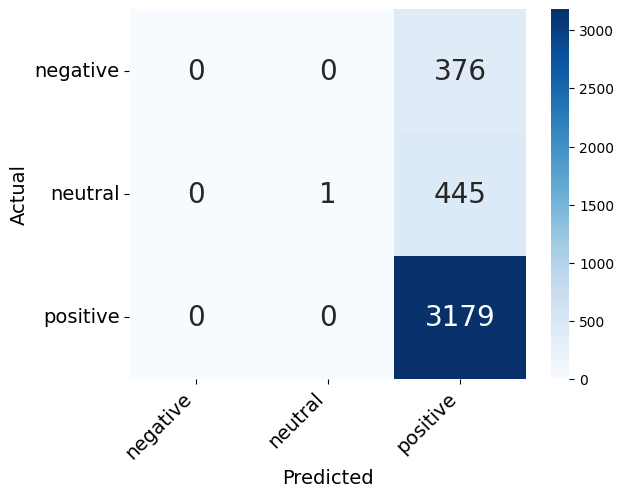

In [ ]:
y_pred = LR.predict(X_test)

con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(
    con_matrix,
    tuple(sentiment_dtypes.categories),
    tuple(sentiment_dtypes.categories),
)

heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
bottom, top = heatmap.get_ylim()
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

Notice our model learned to largely predict positive to improve performance, recall that we have imbalanced data.

In [ ]:
from sklearn.metrics import classification_report


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       376
     neutral       1.00      0.00      0.00       446
    positive       0.79      1.00      0.89      3179

    accuracy                           0.79      4001
   macro avg       0.60      0.33      0.30      4001
weighted avg       0.74      0.79      0.70      4001



Recall on neutral and negative is low, the imbalanced dataset means our classifier can learn to prefer predicting positive labels

## Supervised BERT+PCA/TSNE+Logistic+CV

We have a lot of features from BERT and only so much data. Lets try to filter the noise with TSNE/PCA to improve our ability to learn. Also, lets run K-fold CV to tune parameters.

Compare results with the baseline established above

In [ ]:
# Clean up
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# print(datetime.datetime.now()-nb_start_time)

# This may crash kernel. Save state.
# import dill
# dill.dump_session(session_db)
# If kernel crashed, run this
# dill.load_session(session_db)
with open('/tmp/embeddings.pt', 'wb') as f:
    torch.save(corpus_embeddings, f)

# with open('/tmp/embeddings.pt', 'rb') as f:
#     corpus_embeddings = torch.load(f)

In [ ]:
%time
# How many components should we use? lets check the singular values
# s = scipy.linalg.svdvals(corpus_embeddings)
pca = sklearn.decomposition.PCA()
pca.fit(corpus_embeddings)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


PCA()

In [ ]:
px.line(np.cumsum(pca.explained_variance_ratio_)).show()

BERT is good! We might not gain much here. Lets save 100-200 components to capture 80-90% variance and help training.

TSNE is expensive, try this later. Proceed with PCA for now.

In [ ]:
pca = sklearn.decomposition.PCA(n_components=200)
pca_emebbings = pca.fit_transform(corpus_embeddings)

## Hyperparameter Tuning

In [ ]:
y = review_df.sentiment.values
X = np.array(pca_emebbings) # no need to vstack

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
parameters = {'C': np.linspace(0.05, 1, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters, cv=5, scoring='recall')

grid_search.fit(X_train, y_train)

print('best parameters: ', grid_search.best_params_)
print('best scores: ', grid_search.best_score_)

best parameters:  {'C': 0.05}
best scores:  nan


## Evaluate Best Classifier

In [ ]:
LR = LogisticRegression(C=grid_search.best_params_.get('C'))
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       376
     neutral       0.00      0.00      0.00       446
    positive       0.79      1.00      0.89      3179

    accuracy                           0.79      4001
   macro avg       0.26      0.33      0.30      4001
weighted avg       0.63      0.79      0.70      4001



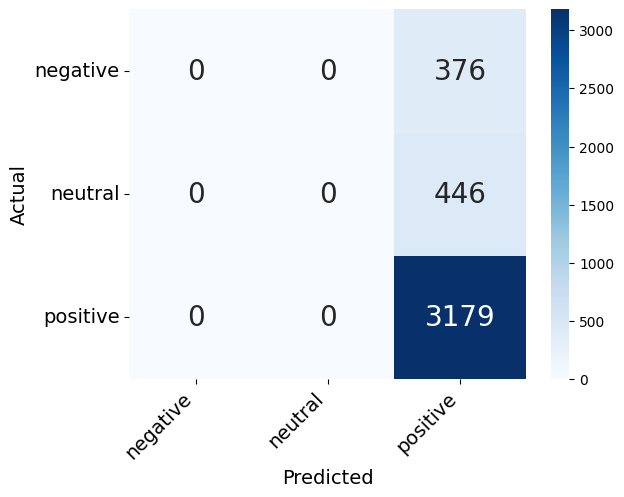

In [ ]:
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(
    con_matrix,
    tuple(sentiment_dtypes.categories),
    tuple(sentiment_dtypes.categories),
)
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
bottom, top = heatmap.get_ylim()
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
print(classification_report(y_test, y_pred))

Likely due to imbalanced classes, dimensionality reduction actually hurt results slightly!

# Word2Ved for Benchmarking

1) Tom's of Maine

In [ ]:
tomsData = pd.read_json('/content/drive/MyDrive/COMP488 Class Project/Data/Amazon/Amazon-TomsofMaine-Reviews-AutoProxyUS.json')
df = tomsData

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [ ]:
# 0 If you have not loaded the model yet, then run this code:
EMBEDDING_FILE = '/content/drive/MyDrive/COMP488 Class Project/GoogleNews-vectors-negative300-500k.bin.gz'

In [ ]:
# 1. Initialise the Word2Vec Model with embedding vector_size = 300, window = 5
# and min_count = 2 i.e. the minimum number of times a word should appear in the corpus
google_model = Word2Vec(vector_size=300, window=5, min_count=10, seed=42)

In [ ]:
wcorpus[:3]

[['love', 'toothpaste', 'teeth', 'looks', 'cleaner', 'using', 'one'],
 ['really', 'good', 'nice', 'soft'],
 ['favorite',
  'toothbrush',
  'im',
  'alway',
  'lookin',
  'one',
  'glad',
  'find',
  'amazon',
  'soft',
  'comfortable',
  'brush']]

In [ ]:
google_model.wv.most_similar(positive=["ingredient"])

[('ingredients', 0.563515841960907),
 ('additive', 0.5158435702323914),
 ('flavoring', 0.5133019685745239),
 ('sweetener', 0.48508793115615845),
 ('derived', 0.4591367840766907),
 ('additives', 0.4573346674442291),
 ('formulation', 0.4387081563472748),
 ('preservatives', 0.4324139952659607),
 ('glycerin', 0.4295080006122589),
 ('recipe', 0.4230564534664154)]

In [ ]:
google_model.wv.most_similar(positive=["natural"])

[('organic', 0.5050569176673889),
 ('healthier', 0.4820166230201721),
 ('chemical', 0.36524325609207153),
 ('safe', 0.36113736033439636),
 ('mainstream', 0.34296584129333496),
 ('unnatural', 0.3393213450908661),
 ('added', 0.33905157446861267),
 ('naturally', 0.3304958641529083),
 ('main', 0.32593923807144165),
 ('wonderful', 0.32388076186180115)]

In [ ]:
google_model.wv.most_similar(positive=["goodmatters"])

NameError: ignored

2.) Colgate Analysis

In [ ]:
# 1. Read the data
colgateData = pd.read_json('/content/drive/MyDrive/COMP488 Class Project/Data/Amazon/Amazon-Colgate-Reviews-AutoProxy-US-20230111.json')
colgateData.head()

,productAsin,username,ratingScore,reviewTitle,reviewUrl,reviewReaction,reviewedIn,date,country,countryCode,reviewDescription,isVerified,avatar,variant,reviewImages,position
0,B08QM33GJ5,Peter,5,A Very Good Toothbrush,None,One person found this helpful,"Reviewed in Canada 🇨🇦 on July 22, 2022",2022-07-22,Canada,🇨🇦,Nice soft bristle’s that give a nice clean fee...,True,https://images-na.ssl-images-amazon.com/images...,Style: Deep Cleansing,[],1
1,B08QM33GJ5,sandip mungala,4,But during sale,None,,"Reviewed in Canada 🇨🇦 on June 19, 2022",2022-06-19,Canada,🇨🇦,Cant find the replacements in store - only ava...,True,https://images-na.ssl-images-amazon.com/images...,Style: Deep Cleansing,[],2
2,B08QM33GJ5,James,3,"Total rip off, but they do brush teeth",None,,"Reviewed in Canada 🇨🇦 on November 1, 2022",2022-11-01,Canada,🇨🇦,It's silly to have more packaging and a higher...,True,https://images-na.ssl-images-amazon.com/images...,Style: Deep Cleansing,[],3
3,B07L5PYX3X,Margie,5,Travel size is the perfect size,https://www.amazon.com/gp/customer-reviews/RKR...,,"Reviewed in the United States 🇺🇸 on July 15, 2021",2021-07-15,United States,🇺🇸,Always feel refreshed and clean after using Co...,True,https://images-na.ssl-images-amazon.com/images...,,[],1
4,B07L5PYX3X,jet black,5,Great product,https://www.amazon.com/gp/customer-reviews/R1Q...,,"Reviewed in the United States 🇺🇸 on July 24, 2021",2021-07-24,United States,🇺🇸,Great product it does work. No problem s would...,True,https://images-na.ssl-images-amazon.com/images...,,[],2


Clean the data:

In [ ]:
# 1. Utitlity functions
# a. Remove ASCII
def remove_non_ascii(s):
    return "".join(i for i in s if ord(i) < 128)

# b. Make all words lower case
def make_lower_case(text):
    return text.lower()

# c. Remove stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# d. Remove HTML
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# e. Remove punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [ ]:
# Let's clean up!

# 2. Make sure the descritions are of type string and create new column to operate on "cleaned"
colgateData['clean'] = colgateData['reviewDescription'].astype(str)

# 3. Pass data into utility functions
colgateData['clean'] = colgateData.clean.apply(remove_non_ascii)
colgateData['clean'] = colgateData.clean.apply(make_lower_case)
colgateData['clean'] = colgateData.clean.apply(remove_stop_words)
colgateData['clean'] = colgateData.clean.apply(remove_punctuation)
colgateData['clean'] = colgateData.clean.apply(remove_html)

In [ ]:
# 4. Split the cleaned description into word tokens
corpus = []
for row in colgateData['clean']:
    corpus.append(row.split())

Retrain Vector

In [ ]:
# 1. Initialise the Word2Vec Model with embedding vector_size = 300, window = 5
# and min_count = 2 i.e. the minimum number of times a word should appear in the corpus
google_model = Word2Vec(vector_size=300, window=5, min_count=10, seed=42)

In [ ]:
%%time
# Note: We have downloaded the pre-trained model already when visualising word vectors using t-SNE

#Step 1: We start by incorporating the vocabulary of our specific corpus into the google model
google_model.build_vocab(corpus)

#Step 2: We obtain the word vectors for the words in the vocabulary that are already present in pre-trained word2vec model.
google_model.wv.vectors_lockf = np.ones(len(google_model.wv))
google_model.wv.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)

#Step 3: We fine-tune the model to learn new contexts of words in our corpus
google_model.train(corpus, total_examples=google_model.corpus_count, epochs = 5)

CPU times: user 35.3 s, sys: 336 ms, total: 35.7 s
Wall time: 28.3 s


(4798035, 5738575)

In [ ]:
# 2. Print the top 10 most similar words using cosine similarity
# Word associations based on Colgate data
google_model.wv.most_similar(positive=["sustainable"])

[('environmentally', 0.4110734164714813),
 ('efficient', 0.4046161472797394),
 ('affordable', 0.4000542461872101),
 ('worthwhile', 0.3988268971443176),
 ('eco', 0.39139002561569214),
 ('economical', 0.385381817817688),
 ('manufactured', 0.37564796209335327),
 ('speedy', 0.3564789295196533),
 ('environmental', 0.35414332151412964),
 ('authentic', 0.35311076045036316)]

In [ ]:
google_model.wv.most_similar(positive=["health"])

[('medical', 0.5395451188087463),
 ('dental', 0.4927174746990204),
 ('care', 0.4665940999984741),
 ('hygiene', 0.46610045433044434),
 ('lichen', 0.4655263423919678),
 ('environmental', 0.4553474187850952),
 ('prevention', 0.43349674344062805),
 ('moderation', 0.43094152212142944),
 ('promoting', 0.4309338927268982),
 ('insurance', 0.42996031045913696)]

In [ ]:
google_model.wv.most_similar(positive=["ingredient"])

[('active', 0.7629776000976562),
 ('ingredients', 0.703438401222229),
 ('triclosan', 0.6224103569984436),
 ('sls', 0.5991840958595276),
 ('sodium', 0.5920960903167725),
 ('additives', 0.5824046730995178),
 ('dioxide', 0.5708611011505127),
 ('sulfate', 0.5472639203071594),
 ('cpc', 0.5352811217308044),
 ('content', 0.5316517353057861)]

In [ ]:
google_model.wv.most_similar(positive=["natural"])

3.) Sensodyne Analysis

In [ ]:
# 1. Read the data
sensoData = pd.read_json('/content/drive/MyDrive/COMP488 Class Project/Data/Amazon/Amazon-Sensodyne-Reviews-AutoProxyUS-20230112.json')
sensoData.head()

,productAsin,username,ratingScore,reviewTitle,reviewUrl,reviewReaction,reviewedIn,date,country,countryCode,reviewDescription,isVerified,avatar,variant,reviewImages,position
0,B078YFVK1L,Lisa D.,5,Gentle and Effective,https://www.amazon.com/gp/customer-reviews/RJS...,,Reviewed in the United States 🇺🇸 on September ...,2021-09-20,United States,🇺🇸,I wish all of my local retailers carried this ...,True,https://images-na.ssl-images-amazon.com/images...,,[],1
1,B078YFVK1L,KAZ,3,Can one control expiration dates on orders...,https://www.amazon.com/gp/customer-reviews/R21...,One person found this helpful,"Reviewed in the United States 🇺🇸 on April 22, ...",2021-04-22,United States,🇺🇸,I like this toothpaste but cannot find it in s...,True,https://images-na.ssl-images-amazon.com/images...,,[],2
2,B00UIBLX7A,Tessa,3,I've only been using this for a few days and ...,https://www.amazon.com/gp/customer-reviews/RQ3...,,"Reviewed in the United States on June 5, 2016",2016-06-05,United States,None,I've only been using this for a few days and i...,True,https://images-na.ssl-images-amazon.com/images...,,[],1
3,B00UIBLX7A,Brent Adrian,5,Five Stars,https://www.amazon.com/gp/customer-reviews/R3S...,,"Reviewed in the United States on October 27, 2016",2016-10-27,United States,None,Great!,True,https://images-na.ssl-images-amazon.com/images...,,[],2
4,B00MOZJX4S,Rory,5,Very good,https://www.amazon.com/gp/customer-reviews/R3D...,,Reviewed in the United States 🇺🇸 on December 1...,2022-12-16,United States,🇺🇸,"My gums were a little swollen, started to blee...",True,https://images-na.ssl-images-amazon.com/images...,,[https://m.media-amazon.com/images/I/619MmGdXQ...,1


Clean Data

In [ ]:
# 1. Utitlity functions
# a. Remove ASCII
def remove_non_ascii(s):
    return "".join(i for i in s if ord(i) < 128)

# b. Make all words lower case
def make_lower_case(text):
    return text.lower()

# c. Remove stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# d. Remove HTML
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# e. Remove punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [ ]:
# Let's clean up!

# 2. Make sure the descritions are of type string and create new column to operate on "cleaned"
sensoData['clean'] = sensoData['reviewDescription'].astype(str)

# 3. Pass data into utility functions
sensoData['clean'] = sensoData.clean.apply(remove_non_ascii)
sensoData['clean'] = sensoData.clean.apply(make_lower_case)
sensoData['clean'] = sensoData.clean.apply(remove_stop_words)
sensoData['clean'] = sensoData.clean.apply(remove_punctuation)
sensoData['clean'] = sensoData.clean.apply(remove_html)

In [ ]:
# 4. Split the cleaned description into word tokens
corpus = []
for row in sensoData['clean']:
    corpus.append(row.split())

Retrain Vector

In [ ]:
# 1. Initialise the Word2Vec Model with embedding vector_size = 300, window = 5
# and min_count = 2 i.e. the minimum number of times a word should appear in the corpus
google_model = Word2Vec(vector_size=300, window=5, min_count=10, seed=42)

In [ ]:
%%time
# Note: We have downloaded the pre-trained model already when visualising word vectors using t-SNE

#Step 1: We start by incorporating the vocabulary of our specific corpus into the google model
google_model.build_vocab(corpus)

#Step 2: We obtain the word vectors for the words in the vocabulary that are already present in pre-trained word2vec model.
google_model.wv.vectors_lockf = np.ones(len(google_model.wv))
google_model.wv.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)

#Step 3: We fine-tune the model to learn new contexts of words in our corpus
google_model.train(corpus, total_examples=google_model.corpus_count, epochs = 5)

CPU times: user 17.6 s, sys: 287 ms, total: 17.9 s
Wall time: 16.1 s


(1056350, 1398215)

In [ ]:
# 2. Print the top 10 most similar words using cosine similarity
# Word associations based on Sensodyne data
google_model.wv.most_similar(positive=["ingredient"])

[('ingredients', 0.7425854802131653),
 ('flavoring', 0.5133019685745239),
 ('glycerin', 0.4959302246570587),
 ('substance', 0.43764710426330566),
 ('active', 0.43262171745300293),
 ('wasnt', 0.43068817257881165),
 ('factor', 0.4140990078449249),
 ('flavor', 0.41266268491744995),
 ('contain', 0.41138559579849243),
 ('silica', 0.3976779580116272)]

In [ ]:
google_model.wv.most_similar(positive=["health"])

[('dental', 0.4686644673347473),
 ('erosion', 0.464824378490448),
 ('medical', 0.4610997140407562),
 ('hygiene', 0.45636117458343506),
 ('care', 0.4449964463710785),
 ('oral', 0.43516454100608826),
 ('b', 0.42838650941848755),
 ('surgery', 0.4175635874271393),
 ('treatment', 0.4154440760612488),
 ('issues', 0.4141862988471985)]

In [ ]:
google_model.wv.most_similar(positive=["sustainable"])
# Sustainable not present in model for sensodyne

KeyError: ignored

In [ ]:
google_model.wv.most_similar(positive=["natural"])

4.) Crest Analysis

In [ ]:
# 1. Read the data
crestData = pd.read_json('/content/drive/MyDrive/COMP488 Class Project/Data/Amazon/Amazon-Crest-Reviews-AutoProxy-US-20230112.json')
crestData.head()

,productAsin,username,ratingScore,reviewTitle,reviewUrl,reviewReaction,reviewedIn,date,country,countryCode,reviewDescription,isVerified,avatar,variant,reviewImages,position
0,B015BQFLI8,Kindle Customer,5,Five Stars,https://www.amazon.com/gp/customer-reviews/RKH...,,"Reviewed in the United States on May 5, 2016",2016-05-05,United States,None,Grandkids loved it.,True,https://images-na.ssl-images-amazon.com/images...,,[],1
1,B07BTBFWC5,Mei C.,5,Convenient small size for traveling,https://www.amazon.com/gp/customer-reviews/R6F...,,"Reviewed in the United States on April 16, 2019",2019-04-16,United States,None,Convenient small size for traveling,True,https://images-na.ssl-images-amazon.com/images...,,[],1
2,B07GZ6656B,DM,1,Title of product is misleading,https://www.amazon.com/gp/customer-reviews/R1H...,,"Reviewed in the United States on October 3, 2022",2022-10-03,United States,None,The title of the product is misleading buyers....,True,https://images-na.ssl-images-amazon.com/images...,,[],1
3,B07GZ743T4,Martin Driscoll,2,Not what it used to be,https://www.amazon.com/gp/customer-reviews/RBY...,,"Reviewed in the United States on September 17,...",2022-09-17,United States,None,Not what it used to be when it was a paste and...,True,https://images-na.ssl-images-amazon.com/images...,,[],1
4,B07GZ743T4,Amazon Customer,1,Not Deep Clean,https://www.amazon.com/gp/customer-reviews/R1E...,One person found this helpful,"Reviewed in the United States on November 29, ...",2022-11-29,United States,None,"I did not receive the deep clean mint, it was ...",True,https://images-na.ssl-images-amazon.com/images...,,[],2


Clean the Data

In [ ]:
# 1. Utitlity functions
# a. Remove ASCII
def remove_non_ascii(s):
    return "".join(i for i in s if ord(i) < 128)

# b. Make all words lower case
def make_lower_case(text):
    return text.lower()

# c. Remove stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# d. Remove HTML
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# e. Remove punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [ ]:
# Let's clean up!

# 2. Make sure the descritions are of type string and create new column to operate on "cleaned"
crestData['clean'] = crestData['reviewDescription'].astype(str)

# 3. Pass data into utility functions
crestData['clean'] = crestData.clean.apply(remove_non_ascii)
crestData['clean'] = crestData.clean.apply(make_lower_case)
crestData['clean'] = crestData.clean.apply(remove_stop_words)
crestData['clean'] = crestData.clean.apply(remove_punctuation)
crestData['clean'] = crestData.clean.apply(remove_html)

In [ ]:
# 4. Split the cleaned description into word tokens
corpus = []
for row in crestData['clean']:
    corpus.append(row.split())

Retrain Vector

In [ ]:
# 1. Initialise the Word2Vec Model with embedding vector_size = 300, window = 5
# and min_count = 2 i.e. the minimum number of times a word should appear in the corpus
google_model = Word2Vec(vector_size=300, window=5, min_count=10, seed=42)

In [ ]:
%%time
# Note: We have downloaded the pre-trained model already when visualising word vectors using t-SNE

#Step 1: We start by incorporating the vocabulary of our specific corpus into the google model
google_model.build_vocab(corpus)

#Step 2: We obtain the word vectors for the words in the vocabulary that are already present in pre-trained word2vec model.
google_model.wv.vectors_lockf = np.ones(len(google_model.wv))
google_model.wv.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)

#Step 3: We fine-tune the model to learn new contexts of words in our corpus
google_model.train(corpus, total_examples=google_model.corpus_count, epochs = 5)

CPU times: user 35.4 s, sys: 325 ms, total: 35.7 s
Wall time: 28.2 s


(4731336, 5695055)

In [ ]:
# 2. Print the top 10 most similar words using cosine similarity
# Word associations based on Sensodyne data
google_model.wv.most_similar(positive=["sustainable"])
# Not present in the crest vocabulary

KeyError: ignored

In [ ]:
google_model.wv.most_similar(positive=["health"])

[('hygiene', 0.4020897150039673),
 ('disease', 0.38647061586380005),
 ('prohealth', 0.36962470412254333),
 ('care', 0.36341720819473267),
 ('series', 0.350816011428833),
 ('detox', 0.35007521510124207),
 ('protection', 0.3407447934150696),
 ('clinical', 0.3255080580711365),
 ('b', 0.31332528591156006),
 ('pandemic', 0.3055010437965393)]

In [ ]:
google_model.wv.most_similar(positive=["ingredient"])

[('sodium', 0.6887997388839722),
 ('cetylpyridinium', 0.6787644624710083),
 ('chloride', 0.6548643112182617),
 ('ingredients', 0.642857551574707),
 ('contain', 0.636809766292572),
 ('flouride', 0.6203843355178833),
 ('sorbitol', 0.5784682631492615),
 ('sls', 0.5718206167221069),
 ('apparently', 0.5614295601844788),
 ('sweetener', 0.5455501079559326)]

In [ ]:
google_model.wv.most_similar(positive=["natural"])

5.) Arm and Hammer Analysis

In [ ]:
# 1. Read the data
armData = pd.read_json("Amazon-ArmHammer-Reviews-AutoProxyUS.json")
armData.head()

,productAsin,username,ratingScore,reviewTitle,reviewUrl,reviewReaction,reviewedIn,date,country,countryCode,reviewDescription,isVerified,avatar,variant,reviewImages,position
0,B00FBQNQKO,Dale,1,good product but,https://www.amazon.com/gp/customer-reviews/RT6...,,Reviewed in the United States 🇺🇸 on December 2...,2013-12-28,United States,🇺🇸,I ordered this toothpaste on my phone. Because...,True,https://images-na.ssl-images-amazon.com/images...,,[],1
1,B00FBQNQKO,uwstef,5,Best toothepaste ever used. My teeth already ...,https://www.amazon.com/gp/customer-reviews/R11...,,Reviewed in the United States 🇺🇸 on February 1...,2014-02-18,United States,🇺🇸,This paste is truly a good one to use for prev...,True,https://images-na.ssl-images-amazon.com/images...,,[],2
2,B00FBQNQKO,EM,5,Five Stars,https://www.amazon.com/gp/customer-reviews/R2M...,,"Reviewed in the United States 🇺🇸 on May 11, 2016",2016-05-11,United States,🇺🇸,My dental hygienist recommended this brand (Ar...,True,https://images-na.ssl-images-amazon.com/images...,,[],3
3,B0014CRQH8,Angie,5,Five Stars,https://www.amazon.com/gp/customer-reviews/R2N...,,"Reviewed in the United States on April 22, 2015",2015-04-22,United States,None,Very good toothpaste,True,https://images-na.ssl-images-amazon.com/images...,,[],1
4,B00Y1QJPKK,Sherry J. Williams,5,Arm & Hammer Truly Radiant Whitening toothe pa...,https://www.amazon.com/gp/customer-reviews/R1C...,,"Reviewed in the United States 🇺🇸 on July 14, 2017",2017-07-14,United States,🇺🇸,"I'm very pleased, this is the only place I've ...",True,https://images-na.ssl-images-amazon.com/images...,,[],1


Clean the Data

In [ ]:
# Let's clean up!

df = pd.read_json('/content/drive/MyDrive/COMP488 Class Project/Data/Amazon/Amazon-ArmHamer-Reviews-AutoProxyUS.json')

# 2. Make sure the descritions are of type string and create new column to operate on "cleaned"
armData['clean'] = armData['reviewDescription'].astype(str)

# 3. Pass data into utility functions
armData['clean'] = armData.clean.apply(remove_non_ascii)
armData['clean'] = armData.clean.apply(make_lower_case)
armData['clean'] = armData.clean.apply(remove_stop_words)
armData['clean'] = armData.clean.apply(remove_punctuation)
armData['clean'] = armData.clean.apply(remove_html)

In [ ]:
# 4. Split the cleaned description into word tokens
corpus = []
for row in armData['clean']:
    corpus.append(row.split())

Retrain Vector

In [ ]:
# 1. Initialise the Word2Vec Model with embedding vector_size = 300, window = 5
# and min_count = 2 i.e. the minimum number of times a word should appear in the corpus
google_model = Word2Vec(vector_size=300, window=5, min_count=10, seed=42)

In [ ]:
%%time
# Note: We have downloaded the pre-trained model already when visualising word vectors using t-SNE

#Step 1: We start by incorporating the vocabulary of our specific corpus into the google model
google_model.build_vocab(corpus)

#Step 2: We obtain the word vectors for the words in the vocabulary that are already present in pre-trained word2vec model.
google_model.wv.vectors_lockf = np.ones(len(google_model.wv))
google_model.wv.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)

#Step 3: We fine-tune the model to learn new contexts of words in our corpus
google_model.train(corpus, total_examples=google_model.corpus_count, epochs = 5)

CPU times: user 25.4 s, sys: 325 ms, total: 25.8 s
Wall time: 22.7 s


(2817731, 3305505)

In [ ]:
# 2. Print the top 10 most similar words using cosine similarity
# Word associations based on Sensodyne data
google_model.wv.most_similar(positive=["sustainable"])
# Not present in the arm and hammer vocabulary

KeyError: ignored

In [ ]:
google_model.wv.most_similar(positive=["health"])

[('hygienist', 0.6067840456962585),
 ('dental', 0.5777638554573059),
 ('sensitivity', 0.5611690878868103),
 ('disease', 0.5491311550140381),
 ('visits', 0.5358974933624268),
 ('periodontal', 0.52680504322052),
 ('hygienists', 0.526607096195221),
 ('healthy', 0.5171127915382385),
 ('cleanings', 0.5109184980392456),
 ('sensodyne', 0.47654369473457336)]

In [ ]:
google_model.wv.most_similar(positive=["ingredient"])

[('lauryl', 0.7354284524917603),
 ('ingredients', 0.7315462827682495),
 ('active', 0.7097076177597046),
 ('sodium', 0.6912423372268677),
 ('sls', 0.667888879776001),
 ('peroxide', 0.6278083920478821),
 ('flouride', 0.6121827363967896),
 ('formulas', 0.5916794538497925),
 ('additives', 0.5791995525360107),
 ('glycerin', 0.5634042024612427)]

In [ ]:
google_model.wv.most_similar(positive=["natural"])